In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline, make_union
from sklearn.feature_selection import chi2, SelectKBest, f_classif, f_regression
from tqdm.notebook import tqdm
from pymorphy2 import MorphAnalyzer
from functools import partial
from stop_words import get_stop_words
import pandas as pd
import numpy as np
import json

import os
import re

SEED = 21

tqdm.pandas()

In [2]:
PATH = '../data'

In [3]:
# df = pd.read_csv(os.path.join(PATH, 'RuMedPrimeData.zip'), sep='\t', compression='zip')


# df_train, df_val, df_test = np.split(
#     df.sample(frac=1, random_state=SEED), 
#     [int(0.735*len(df)), int(0.8675*len(df))]
# )
# df_train.to_csv(os.path.join(PATH, 'train.csv'))
# df_val.to_csv(os.path.join(PATH, 'val.csv'))
# df_test.to_csv(os.path.join(PATH, 'test.csv'))

In [4]:
df_train = pd.read_csv(os.path.join(PATH, 'train.csv'))
df_val = pd.read_csv(os.path.join(PATH, 'val.csv'))
df_test = pd.read_csv(os.path.join(PATH, 'test.csv'))

In [5]:
def norm_form(list_words, morph):
    return [morph.parse(word)[0].normal_form for word in list_words]

def del_stopwords(list_words, stop_words):
    return [word for word in list_words if word not in stop_words]

def transform_data(df):
    df = df.copy()
    df['level_2'] = df['icd10'].str.split('.').apply(lambda x: x[0])
    df['level_1'] = df['icd10'].apply(lambda x: x[0])
    df['symptoms_tokens'] = df['symptoms'] \
        .str.lower() \
        .str.split('[^a-zа-яё]+') \
        .progress_apply(partial(norm_form, morph=MorphAnalyzer())) \
        .progress_apply(partial(del_stopwords, stop_words=get_stop_words('russian')))
    return df

In [6]:
X_train = transform_data(df_train)
X_val = transform_data(df_val)
X_test = transform_data(df_test)


i2l = dict(enumerate(sorted(X_train['level_1'].unique())))
l2i = {label: i for i, label in i2l.items()}

y_train = X_train['level_1'].map(l2i).values
y_val = X_val['level_1'].map(l2i).fillna(np.max(y_train)+1).values
y_test = X_test['level_1'].map(l2i).fillna(np.max(y_train)+1).values

  0%|          | 0/5604 [00:00<?, ?it/s]

  0%|          | 0/5604 [00:00<?, ?it/s]

  0%|          | 0/1010 [00:00<?, ?it/s]

  0%|          | 0/1010 [00:00<?, ?it/s]

  0%|          | 0/1011 [00:00<?, ?it/s]

  0%|          | 0/1011 [00:00<?, ?it/s]

In [101]:
class FeatureSelector(BaseEstimator, TransformerMixin):

    def __init__(self, col):
        self.col = col
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.col]
        
    def fit_transform(self, X, y=None):
        return self.transform(X)
    
    
def hit_at_n(y_true, y_pred, n=3):
    assert len(y_true) == len(y_pred)
    score = np.mean(np.any(
        np.argsort(-y_pred, axis=1)[:, :n] == y_true.reshape(-1,1), 
        axis=1
    ))
    return score


def scorer_hit_at_3(estimator, X, y):
    y_pred = estimator.predict_proba(X)
    score = hit_at_n(y, y_pred, n=3)
    return score


def scorer_precision(estimator, X, y):
    y_pred = estimator.predict_proba(X)
    score = hit_at_n(y, y_pred, n=1)
    return score

In [103]:
%%time

model = make_pipeline(
    FeatureSelector('symptoms'),
    TfidfVectorizer(analyzer='char', ngram_range=(3, 8), lowercase=True),
    LogisticRegression(penalty='l2', C=10, multi_class='ovr', n_jobs=-1)
)
model.fit(X_train, y_train)

Pipeline(steps=[('featureselector', FeatureSelector(col='symptoms')),
                ('tfidfvectorizer',
                 TfidfVectorizer(analyzer='char', ngram_range=(3, 8))),
                ('logisticregression',
                 LogisticRegression(C=10, multi_class='ovr', n_jobs=-1))])

In [112]:
model[-1].coef_.shape

(436, 851384)

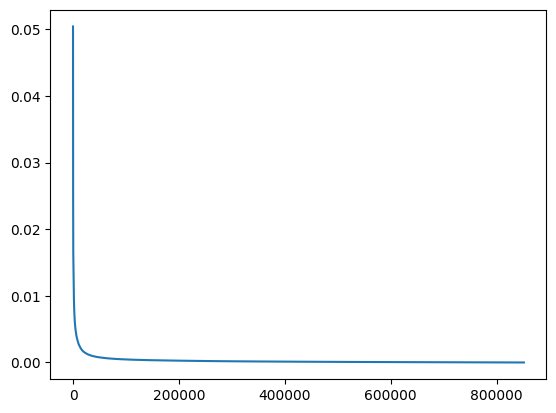

In [128]:
plt.plot(-np.sort(-np.abs(np.mean(model[-1].coef_, axis=0))));

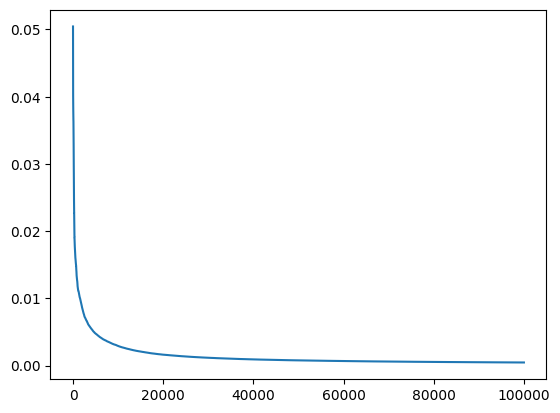

In [130]:
plt.plot(-np.sort(-np.abs(np.mean(model[-1].coef_, axis=0)))[:100000]);

In [90]:
scorer_hit_at_3(model, X_val, y_val), scorer_precision(model, X_val, y_val)

(0.6376237623762376, 0.41386138613861384)

In [89]:
scorer_hit_at_3(model, X_test, y_test), scorer_precision(model, X_test, y_test)

(0.636003956478734, 0.41641938674579626)

In [149]:
%%time

model = make_pipeline(
    FeatureSelector('symptoms'),
    TfidfVectorizer(analyzer='char', ngram_range=(3, 8), lowercase=True),
    SelectKBest(chi2, k=100000),
    LogisticRegression(penalty='l2', C=10, multi_class='ovr', n_jobs=-1)
)
model.fit(X_train, y_train)

CPU times: user 19.7 s, sys: 3.08 s, total: 22.8 s
Wall time: 1min 17s


Pipeline(steps=[('featureselector', FeatureSelector(col='symptoms')),
                ('tfidfvectorizer',
                 TfidfVectorizer(analyzer='char', ngram_range=(3, 8))),
                ('selectkbest',
                 SelectKBest(k=100000,
                             score_func=<function chi2 at 0x7f8b59f03310>)),
                ('logisticregression',
                 LogisticRegression(C=10, multi_class='ovr', n_jobs=-1))])

In [150]:
scorer_hit_at_3(model, X_val, y_val), scorer_precision(model, X_val, y_val)

(0.5524752475247525, 0.3465346534653465)

In [151]:
scorer_hit_at_3(model, X_test, y_test), scorer_precision(model, X_test, y_test)

(0.5578635014836796, 0.34817012858555885)

In [155]:
%%time

model = make_pipeline(
    FeatureSelector('symptoms'),
    TfidfVectorizer(analyzer='char', ngram_range=(3, 8), lowercase=True),
    SelectKBest(chi2, k=300000),
    LogisticRegression(penalty='l2', C=10, multi_class='ovr', n_jobs=-1)
)
model.fit(X_train, y_train)

CPU times: user 21 s, sys: 4.85 s, total: 25.8 s
Wall time: 4min 2s


Pipeline(steps=[('featureselector', FeatureSelector(col='symptoms')),
                ('tfidfvectorizer',
                 TfidfVectorizer(analyzer='char', ngram_range=(3, 8))),
                ('selectkbest',
                 SelectKBest(k=300000,
                             score_func=<function chi2 at 0x7f8b59f03310>)),
                ('logisticregression',
                 LogisticRegression(C=10, multi_class='ovr', n_jobs=-1))])

In [156]:
scorer_hit_at_3(model, X_val, y_val), scorer_precision(model, X_val, y_val)

(0.6257425742574257, 0.400990099009901)

In [157]:
scorer_hit_at_3(model, X_test, y_test), scorer_precision(model, X_test, y_test)

(0.6300692383778437, 0.4025717111770524)

In [145]:
%%time

model = make_pipeline(
    FeatureSelector('symptoms_tokens'),
    TfidfVectorizer(tokenizer=lambda x: x, lowercase=False),
    LogisticRegression(penalty='l2', C=10, multi_class='ovr', n_jobs=-1)
)
model.fit(X_train, y_train)

CPU times: user 691 ms, sys: 120 ms, total: 811 ms
Wall time: 3.39 s


Pipeline(steps=[('featureselector', FeatureSelector(col='symptoms_tokens')),
                ('tfidfvectorizer',
                 TfidfVectorizer(lowercase=False,
                                 tokenizer=<function <lambda> at 0x7f8b2fb82c10>)),
                ('logisticregression',
                 LogisticRegression(C=10, multi_class='ovr', n_jobs=-1))])

In [146]:
scorer_hit_at_3(model, X_val, y_val), scorer_precision(model, X_val, y_val)

(0.6346534653465347, 0.4069306930693069)

In [148]:
scorer_hit_at_3(model, X_test, y_test), scorer_precision(model, X_test, y_test)

(0.6261127596439169, 0.3897131552917903)

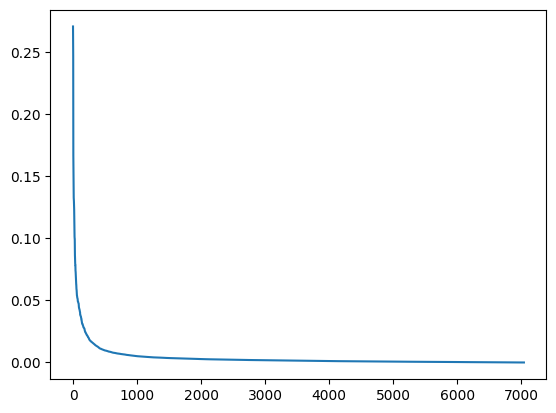

In [147]:
plt.plot(-np.sort(-np.abs(np.mean(model[-1].coef_, axis=0))));

In [152]:
%%time

model = make_pipeline(
    FeatureSelector('symptoms_tokens'),
    TfidfVectorizer(tokenizer=lambda x: x, lowercase=False),
    SelectKBest(chi2, k=3000),
    LogisticRegression(penalty='l2', C=10, multi_class='ovr', n_jobs=-1)
)
model.fit(X_train, y_train)

CPU times: user 832 ms, sys: 1.08 s, total: 1.91 s
Wall time: 1.83 s


Pipeline(steps=[('featureselector', FeatureSelector(col='symptoms_tokens')),
                ('tfidfvectorizer',
                 TfidfVectorizer(lowercase=False,
                                 tokenizer=<function <lambda> at 0x7f8bb7934700>)),
                ('selectkbest',
                 SelectKBest(k=3000,
                             score_func=<function chi2 at 0x7f8b59f03310>)),
                ('logisticregression',
                 LogisticRegression(C=10, multi_class='ovr', n_jobs=-1))])

In [153]:
scorer_hit_at_3(model, X_val, y_val), scorer_precision(model, X_val, y_val)

(0.6207920792079208, 0.403960396039604)

In [154]:
scorer_hit_at_3(model, X_test, y_test), scorer_precision(model, X_test, y_test)

(0.6172106824925816, 0.3847675568743818)

In [159]:
from gensim.models import Word2Vec

In [251]:
class W2V(BaseEstimator, TransformerMixin):

    def __init__(self, vector_size):
        self.vector_size = vector_size
        self.model_w2v = None
        
    def get_w2v(self, list_words):
        new_list_words = [word for word in list_words if word in self.model_w2v.index_to_key]
        if len(new_list_words):
            vector = list(np.mean(self.model_w2v[new_list_words], axis=0))
        else:
            vector = list(np.zeros(self.vector_size))
        return vector
        
    def fit(self, X, y=None):
        self.model_w2v = Word2Vec(
            X, 
            min_count=1, 
            vector_size=self.vector_size, 
            workers=16,
            window=5,
        ).wv
        return self
    
    def transform(self, X, y=None):
        vectors = np.array(list(map(self.get_w2v, X)))
        return vectors

In [254]:
%%time

model = make_pipeline(
    FeatureSelector('symptoms_tokens'),
    W2V(300),
    LogisticRegression(penalty='l2', C=10, multi_class='ovr', n_jobs=-1)
)
model.fit(X_train, y_train)

CPU times: user 4.9 s, sys: 178 ms, total: 5.08 s
Wall time: 16.3 s


Pipeline(steps=[('featureselector', FeatureSelector(col='symptoms_tokens')),
                ('w2v', W2V(vector_size=1000)),
                ('logisticregression',
                 LogisticRegression(C=10, multi_class='ovr', n_jobs=-1))])

In [255]:
scorer_hit_at_3(model, X_val, y_val), scorer_precision(model, X_val, y_val)

(0.43465346534653465, 0.25544554455445545)